# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [22]:


def grow_tree(data, min_samples_split=2, max_depth=5, min_samples_leaf=1, depth=0):
    X, Y = data[:, :-1], data[:, -1]  
    n_samples, n_features = X.shape

    # Stopping Conditions
    if (pure_node(Y) or max_depth_reached(depth, max_depth) or min_samples_split_reached(n_samples, min_samples_split) or n_samples <= min_samples_leaf):
        return {"value": most_common_label(Y)}

    #  Find Best Split
    best_split = find_best_split(data)
    if best_split["info_gain"] == 0:
        return {"value": most_common_label(Y)}

    #  Recursively Grow Left & Right Subtrees (Passing min_samples_leaf)
    left_subtree = grow_tree(best_split["dataset_left"], min_samples_split, max_depth, min_samples_leaf, depth + 1)
    right_subtree = grow_tree(best_split["dataset_right"], min_samples_split, max_depth, min_samples_leaf, depth + 1)

    return {
        "feature_index": best_split["feature_index"],
        "threshold": best_split["threshold"],
        "left": left_subtree,
        "right": right_subtree
    }

def most_common_label(Y):
    unique_labels, counts = np.unique(Y, return_counts=True)
    return unique_labels[np.argmax(counts)]


### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [23]:
def pure_node(Y):
     return len(np.unique(Y)) == 1

def max_depth_reached(depth, max_depth):
    return depth >= max_depth

def min_samples_split_reached(n_samples, min_samples_split):
     return n_samples < min_samples_split


### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [24]:
def find_best_split(dataset):
   
    n_samples, n_features = dataset.shape[0], dataset.shape[1] - 1
    best_split = {"info_gain": 0}

    for feature_index in range(n_features):
        feature_values = dataset[:, feature_index]
        is_numeric = np.issubdtype(feature_values.dtype, np.number)
        thresholds = [np.median(feature_values)] if is_numeric else np.unique(feature_values)

        for threshold in thresholds:
            left_data, right_data = split_data(dataset, feature_index, threshold)
            if len(left_data) == 0 or len(right_data) == 0:
                continue

            parent_labels, left_labels, right_labels = dataset[:, -1], left_data[:, -1], right_data[:, -1]
            info_gain = information_gain(parent_labels, left_labels, right_labels)

            if info_gain > best_split["info_gain"]:
                best_split = {
                    "feature_index": feature_index,
                    "threshold": threshold,
                    "dataset_left": left_data,
                    "dataset_right": right_data,
                    "info_gain": info_gain
                }

    return best_split

def information_gain(parent_labels, left_labels, right_labels):
    p_left = len(left_labels) / len(parent_labels)
    p_right = len(right_labels) / len(parent_labels)

    gain = entropy(parent_labels) - (p_left * entropy(left_labels) + p_right * entropy(right_labels))
    return gain

def entropy(labels):
    class_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9)) 


### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [25]:
def split_data(data, feature_index, threshold):
   
    feature_values = data[:, feature_index]

    if np.issubdtype(feature_values.dtype, np.number): 
        left_subset = data[feature_values <= threshold]
        right_subset = data[feature_values > threshold]
    else: 
        left_subset = data[feature_values == threshold]
        right_subset = data[feature_values != threshold]

    return left_subset, right_subset



### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [26]:
def predict_with_tree(tree, X):
   
    return np.array([traverse_tree(tree, sample) for sample in X])

def traverse_tree(tree, sample):
    
    if "value" in tree:
        return tree["value"]

    feature_index = tree["feature_index"]
    threshold = tree["threshold"]

    return traverse_tree(tree["left"], sample) if sample[feature_index] <= threshold else traverse_tree(tree["right"], sample)



## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [27]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [28]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

Run 1: My Decision Tree Accuracy = 0.8611, Scikit-Learn Accuracy = 0.9444
Run 2: My Decision Tree Accuracy = 0.9167, Scikit-Learn Accuracy = 1.0000
Run 3: My Decision Tree Accuracy = 0.9444, Scikit-Learn Accuracy = 0.9167
Run 4: My Decision Tree Accuracy = 0.8889, Scikit-Learn Accuracy = 0.8333
Run 5: My Decision Tree Accuracy = 0.9167, Scikit-Learn Accuracy = 0.9444


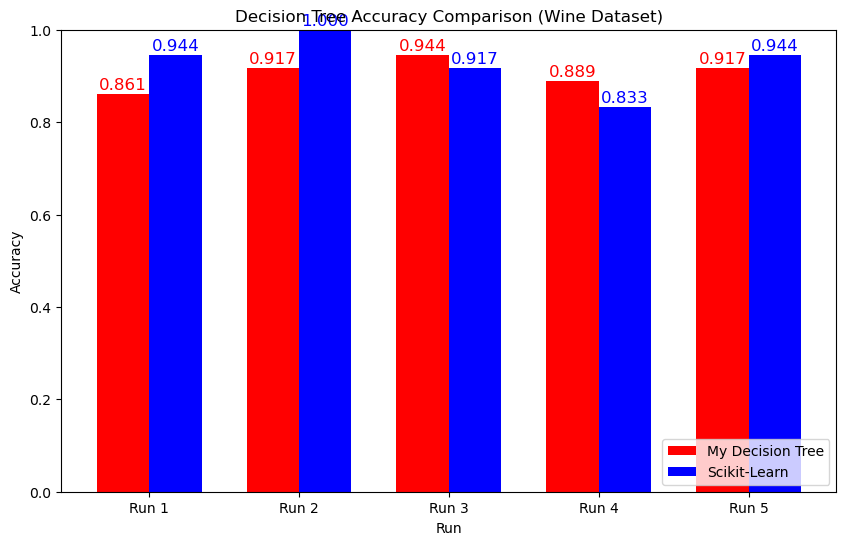

In [29]:

from sklearn.preprocessing import LabelEncoder

# --- Load Wine dataset ---
data_wine = pd.read_csv("wine.csv")

# 🔹 Encode categorical features if needed
label_encoders = {}
for col in data_wine.columns:  
    if data_wine[col].dtype == 'object':  # Check if column is categorical
        label_encoders[col] = LabelEncoder()
        data_wine[col] = label_encoders[col].fit_transform(data_wine[col])  

# Convert dataset to NumPy array for training
data_wine = data_wine.to_numpy()

# Number of runs for evaluation
num_runs = 5
my_tree_accuracies = []
sklearn_tree_accuracies = []

for run in range(num_runs):
    np.random.seed(run) 
    np.random.shuffle(data_wine)  

    X, Y = data_wine[:, :-1], data_wine[:, -1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=run)

    # Train and test My Decision Tree
    my_tree = grow_tree(np.column_stack((X_train, Y_train)), min_samples_split=5, max_depth=5)  
    my_predictions = predict_with_tree(my_tree, X_test)

    # Ensure predictions are in integer format
    my_predictions = np.array(my_predictions).astype(int)

    # Calculate accuracy for my decision tree
    my_accuracy = accuracy_score(Y_test, my_predictions)

    # Train and test Scikit-Learn's Decision Tree
    sklearn_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=5)  
    sklearn_tree.fit(X_train, Y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracy = accuracy_score(Y_test, sklearn_predictions)

    # Store results
    my_tree_accuracies.append(round(my_accuracy, 4))
    sklearn_tree_accuracies.append(round(sklearn_accuracy, 4))

    # Print accuracy results
    print(f"Run {run + 1}: My Decision Tree Accuracy = {my_accuracy:.4f}, Scikit-Learn Accuracy = {sklearn_accuracy:.4f}")

# --- Plot results ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
x_labels = [f"Run {i+1}" for i in range(num_runs)]
x = np.arange(len(x_labels))

# Plot bars
plt.bar(x - bar_width/2, my_tree_accuracies, bar_width, label="My Decision Tree", color="red")
plt.bar(x + bar_width/2, sklearn_tree_accuracies, bar_width, label="Scikit-Learn", color="blue")

# Add text annotations
for i in range(num_runs):
    plt.text(i - bar_width/2, my_tree_accuracies[i] + 0.01, f"{my_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="red")
    plt.text(i + bar_width/2, sklearn_tree_accuracies[i] + 0.01, f"{sklearn_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="blue")

# Labels and title
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy Comparison (Wine Dataset)")
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.legend(loc="lower right")

plt.show()



### 7) Dataset 2: Heart Disease

Run 1: My Decision Tree Accuracy = 0.8683, Scikit-Learn Accuracy = 0.9122
Run 2: My Decision Tree Accuracy = 0.8293, Scikit-Learn Accuracy = 0.8732
Run 3: My Decision Tree Accuracy = 0.8683, Scikit-Learn Accuracy = 0.9268
Run 4: My Decision Tree Accuracy = 0.8732, Scikit-Learn Accuracy = 0.8976
Run 5: My Decision Tree Accuracy = 0.8195, Scikit-Learn Accuracy = 0.8634


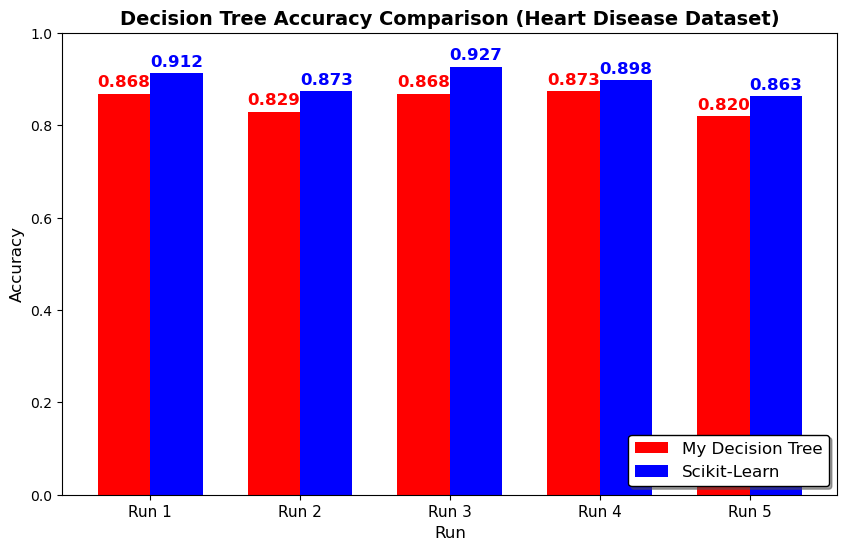

In [30]:

# --- Load Heart Disease dataset ---
data_heart = pd.read_csv("heart.csv")

#  Encode categorical features if needed
label_encoders = {}
for col in data_heart.columns:  
    if data_heart[col].dtype == 'object':  # Check if column is categorical
        label_encoders[col] = LabelEncoder()
        data_heart[col] = label_encoders[col].fit_transform(data_heart[col])  # Encode

# Convert dataset to NumPy array for training
data_heart = data_heart.to_numpy()

# Number of runs for evaluation
num_runs = 5
my_tree_accuracies = []
sklearn_tree_accuracies = []

for run in range(num_runs):
    np.random.shuffle(data_heart)  # Shuffle before splitting
    X, Y = data_heart[:, :-1], data_heart[:, -1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=run)

    # Train and test my implemented decision tree
    my_tree = grow_tree(np.column_stack((X_train, Y_train)))  
    my_predictions = predict_with_tree(my_tree, X_test)

    # Ensure predictions are in integer format
    my_predictions = np.array(my_predictions).astype(int)

    # Calculate accuracy for my decision tree
    my_accuracy = accuracy_score(Y_test, my_predictions)

    # Train and test Scikit-Learn's decision tree 
    sklearn_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)  
    sklearn_tree.fit(X_train, Y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracy = accuracy_score(Y_test, sklearn_predictions)

    # Store results
    my_tree_accuracies.append(round(my_accuracy, 4))
    sklearn_tree_accuracies.append(round(sklearn_accuracy, 4))

    # Print accuracy results
    print(f"Run {run + 1}: My Decision Tree Accuracy = {my_accuracy:.4f}, Scikit-Learn Accuracy = {sklearn_accuracy:.4f}")

# --- Plot results ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
x_labels = [f"Run {i+1}" for i in range(num_runs)]
x = np.arange(len(x_labels))

# Plot bars
plt.bar(x - bar_width/2, my_tree_accuracies, bar_width, label="My Decision Tree", color="red")
plt.bar(x + bar_width/2, sklearn_tree_accuracies, bar_width, label="Scikit-Learn", color="blue")

#  Improve text annotations
for i in range(num_runs):
    plt.text(i - bar_width/2, my_tree_accuracies[i] + 0.015, f"{my_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="red", fontweight="bold")
    plt.text(i + bar_width/2, sklearn_tree_accuracies[i] + 0.015, f"{sklearn_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="blue", fontweight="bold")

# Labels and title
plt.xlabel("Run", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Decision Tree Accuracy Comparison (Heart Disease Dataset)", fontsize=14, fontweight="bold")
plt.xticks(x, x_labels, fontsize=11)
plt.ylim(0, 1)

#  Adjust legend position for better visibility
plt.legend(loc="lower right", fontsize=12, edgecolor="black", shadow=True)

plt.show()


### 8) Dataset 3: Car

Run 1: My Decision Tree Accuracy = 0.7861, Scikit-Learn Accuracy = 0.8699
Run 2: My Decision Tree Accuracy = 0.7659, Scikit-Learn Accuracy = 0.8699
Run 3: My Decision Tree Accuracy = 0.7254, Scikit-Learn Accuracy = 0.8439
Run 4: My Decision Tree Accuracy = 0.7486, Scikit-Learn Accuracy = 0.8613
Run 5: My Decision Tree Accuracy = 0.7254, Scikit-Learn Accuracy = 0.8410


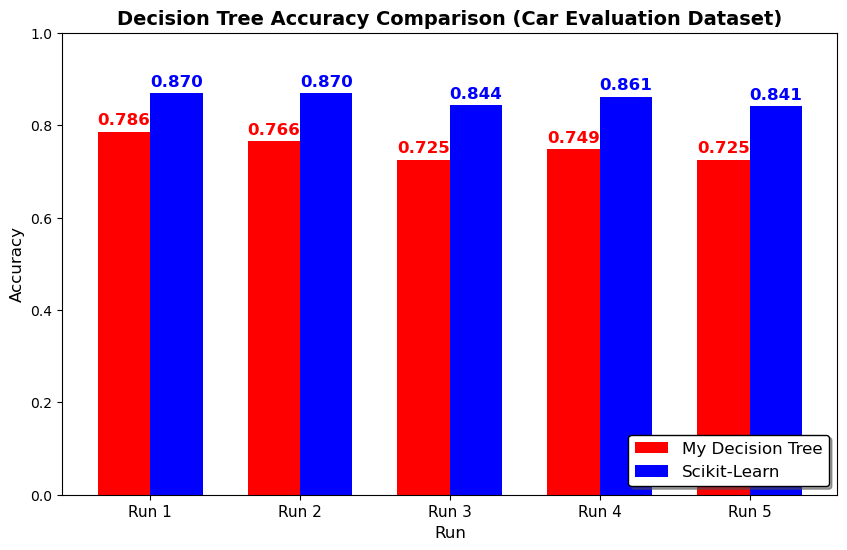

In [31]:


# Load Car Evaluation dataset
data_car = pd.read_csv("car.csv")
# Encode categorical features
label_encoders = {}
for col in data_car.columns:
    label_encoders[col] = LabelEncoder()
    data_car[col] = label_encoders[col].fit_transform(data_car[col])

# Convert dataset to NumPy array
data_car = data_car.to_numpy()

# Number of evaluation runs
num_runs = 5
my_tree_accuracies = []
sklearn_tree_accuracies = []

for run in range(num_runs):
    np.random.shuffle(data_car)  # Shuffle before splitting
    X, Y = data_car[:, :-1], data_car[:, -1]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=run)

    # Train and test my implemented decision tree
    my_tree = grow_tree(np.column_stack((X_train, Y_train)), max_depth=5)  
    my_predictions = predict_with_tree(my_tree, X_test)

    # Ensure predictions are integers
    my_predictions = np.array(my_predictions).astype(int)

    # Calculate accuracy for my decision tree
    my_accuracy = accuracy_score(Y_test, my_predictions)

    # Train and test Scikit-Learn's decision tree
    sklearn_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)  
    sklearn_tree.fit(X_train, Y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracy = accuracy_score(Y_test, sklearn_predictions)

    # Store results
    my_tree_accuracies.append(round(my_accuracy, 4))
    sklearn_tree_accuracies.append(round(sklearn_accuracy, 4))

    # Print accuracy results
    print(f"Run {run + 1}: My Decision Tree Accuracy = {my_accuracy:.4f}, Scikit-Learn Accuracy = {sklearn_accuracy:.4f}")

# --- Plot results ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
x_labels = [f"Run {i+1}" for i in range(num_runs)]
x = np.arange(len(x_labels))

# Plot bars
plt.bar(x - bar_width/2, my_tree_accuracies, bar_width, label="My Decision Tree", color="red")
plt.bar(x + bar_width/2, sklearn_tree_accuracies, bar_width, label="Scikit-Learn", color="blue")

# Improve text annotations
for i in range(num_runs):
    plt.text(i - bar_width/2, my_tree_accuracies[i] + 0.015, f"{my_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="red", fontweight="bold")
    plt.text(i + bar_width/2, sklearn_tree_accuracies[i] + 0.015, f"{sklearn_tree_accuracies[i]:.3f}", ha="center", fontsize=12, color="blue", fontweight="bold")

# Labels and title
plt.xlabel("Run", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Decision Tree Accuracy Comparison (Car Evaluation Dataset)", fontsize=14, fontweight="bold")
plt.xticks(x, x_labels, fontsize=11)
plt.ylim(0, 1)

# Adjust legend position for better visibility
plt.legend(loc="lower right", fontsize=12, edgecolor="black", shadow=True)

plt.show()


### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Scikit-learn Accuracy (No Preprocessing) Run 1: 0.9167
Custom Tree Accuracy (No Preprocessing) Run 1: 1.0000
Scikit-learn Accuracy (With Preprocessing) Run 1: 0.9167
Custom Tree Accuracy (With Preprocessing) Run 1: 0.9167

Scikit-learn Accuracy (No Preprocessing) Run 2: 0.9167
Custom Tree Accuracy (No Preprocessing) Run 2: 0.9444
Scikit-learn Accuracy (With Preprocessing) Run 2: 0.9167
Custom Tree Accuracy (With Preprocessing) Run 2: 0.8333

Scikit-learn Accuracy (No Preprocessing) Run 3: 0.9167
Custom Tree Accuracy (No Preprocessing) Run 3: 0.8611
Scikit-learn Accuracy (With Preprocessing) Run 3: 0.9167
Custom Tree Accuracy (With Preprocessing) Run 3: 0.9444

Scikit-learn Accuracy (No Preprocessing) Run 4: 0.8333
Custom Tree Accuracy (No Preprocessing) Run 4: 0.9722
Scikit-learn Accuracy (With Preprocessing) Run 4: 0.8333
Custom Tree Accuracy (With Preprocessing) Run 4: 0.8333

Scikit-learn Accuracy (No Preprocessing) Run 5: 0.9722
Custom Tree Accuracy (No Preprocessing) Run 5: 1.0000

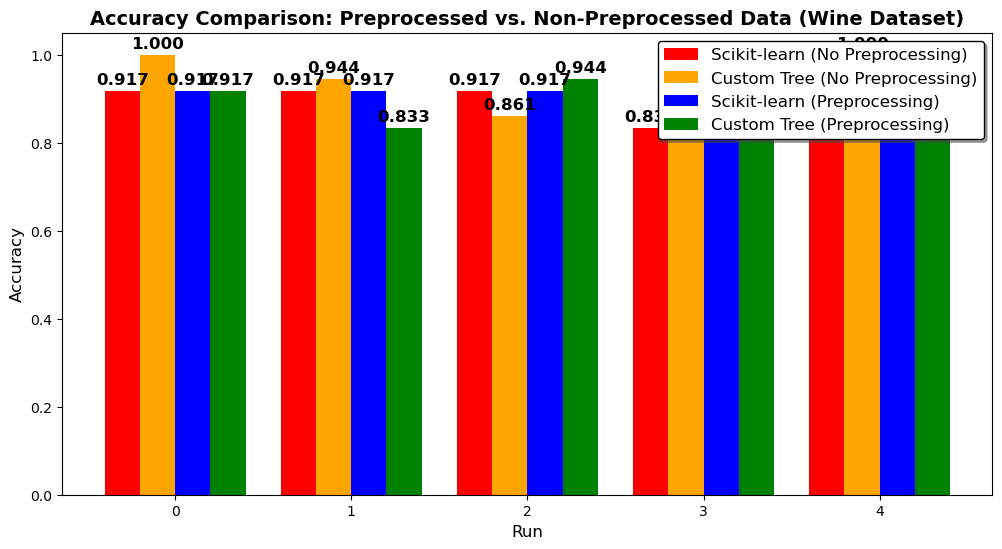


Average Accuracies
Average Scikit-learn Accuracy (No Preprocessing): 0.9111
Average Custom Tree Accuracy (No Preprocessing): 0.9555
Average Scikit-learn Accuracy (With Preprocessing): 0.9111
Average Custom Tree Accuracy (With Preprocessing): 0.9000


In [32]:
from sklearn import preprocessing
# --- Load Wine Dataset ---
data_wine = pd.read_csv("wine.csv")

#  Encode categorical features if needed
label_encoders = {}
for col in data_wine.columns:
    if data_wine[col].dtype == 'object':  # Check if column is categorical
        label_encoders[col] = LabelEncoder()
        data_wine[col] = label_encoders[col].fit_transform(data_wine[col])  

# Convert dataset to NumPy array
data_wine = data_wine.to_numpy()

# Separate features and labels
X = data_wine[:, :-1]  # Features
Y = data_wine[:, -1]   # Labels (do not scale)


class_counts = np.bincount(Y.astype(int))
rare_classes = np.where(class_counts < 2)[0]
valid_indices = np.isin(Y, rare_classes, invert=True)
X, Y = X[valid_indices], Y[valid_indices]

#  Normalize features BEFORE splitting to ensure same train-test sets
X_scaled = preprocessing.normalize(X)

# Number of runs for evaluation
num_runs = 5
my_tree_accuracies_raw = []
sklearn_tree_accuracies_raw = []
my_tree_accuracies_scaled = []
sklearn_tree_accuracies_scaled = []

for run in range(num_runs):
    np.random.seed(run)  # Ensure consistency across runs
    
    # Ensure SAME train-test split indices for both raw and preprocessed data
    try:
        train_indices, test_indices = train_test_split(np.arange(len(X)), test_size=0.2, random_state=run, stratify=Y)
    except ValueError:
        print(f"Warning: Stratified split failed in Run {run+1}. Using random split instead.")
        train_indices, test_indices = train_test_split(np.arange(len(X)), test_size=0.2, random_state=run)

    # Apply the same indices to both raw and scaled features
    X_train_raw, X_test_raw = X[train_indices], X[test_indices]
    X_train_scaled, X_test_scaled = X_scaled[train_indices], X_scaled[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]

    #  Train and test My Decision Tree (Raw Data)
    my_tree_raw = grow_tree(np.column_stack((X_train_raw, Y_train)), min_samples_split=3, max_depth=5)  
    my_predictions_raw = predict_with_tree(my_tree_raw, X_test_raw)
    my_predictions_raw = np.array(my_predictions_raw).astype(int)
    my_accuracy_raw = accuracy_score(Y_test, my_predictions_raw)

    # Train and test Scikit-Learn’s Decision Tree (Raw Data)
    sklearn_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=run)  
    sklearn_tree.fit(X_train_raw, Y_train)  # Always train on raw features
    sklearn_predictions_raw = sklearn_tree.predict(X_test_raw)
    sklearn_accuracy_raw = accuracy_score(Y_test, sklearn_predictions_raw)

    #  Train and test My Decision Tree (Normalized Data)
    my_tree_scaled = grow_tree(np.column_stack((X_train_scaled, Y_train)), min_samples_split=3, max_depth=5)  
    my_predictions_scaled = predict_with_tree(my_tree_scaled, X_test_scaled)
    my_predictions_scaled = np.array(my_predictions_scaled).astype(int)
    my_accuracy_scaled = accuracy_score(Y_test, my_predictions_scaled)

    # Train and test Scikit-Learn’s Decision Tree 
    sklearn_predictions_scaled = sklearn_tree.predict(X_test_raw) 
    sklearn_accuracy_scaled = accuracy_score(Y_test, sklearn_predictions_scaled)

    # Store results
    my_tree_accuracies_raw.append(round(my_accuracy_raw, 4))
    sklearn_tree_accuracies_raw.append(round(sklearn_accuracy_raw, 4))
    my_tree_accuracies_scaled.append(round(my_accuracy_scaled, 4))
    sklearn_tree_accuracies_scaled.append(round(sklearn_accuracy_scaled, 4))

    # Print accuracy results
    print(f"Scikit-learn Accuracy (No Preprocessing) Run {run + 1}: {sklearn_accuracy_raw:.4f}")
    print(f"Custom Tree Accuracy (No Preprocessing) Run {run + 1}: {my_accuracy_raw:.4f}")
    print(f"Scikit-learn Accuracy (With Preprocessing) Run {run + 1}: {sklearn_accuracy_scaled:.4f}")  
    print(f"Custom Tree Accuracy (With Preprocessing) Run {run + 1}: {my_accuracy_scaled:.4f}\n")

#  Calculate & Print Averages
avg_sklearn_raw = np.mean(sklearn_tree_accuracies_raw)
avg_my_tree_raw = np.mean(my_tree_accuracies_raw)
avg_sklearn_scaled = np.mean(sklearn_tree_accuracies_scaled)
avg_my_tree_scaled = np.mean(my_tree_accuracies_scaled)

# --- Plot results ---
plt.figure(figsize=(12, 6))
bar_width = 0.2
x_labels = [f"Run {i+1}" for i in range(num_runs)]
x = np.arange(len(x_labels))

# Plot bars
plt.bar(x - 1.5 * bar_width, sklearn_tree_accuracies_raw, bar_width, label="Scikit-learn (No Preprocessing)", color="red")
plt.bar(x - 0.5 * bar_width, my_tree_accuracies_raw, bar_width, label="Custom Tree (No Preprocessing)", color="orange")
plt.bar(x + 0.5 * bar_width, sklearn_tree_accuracies_scaled, bar_width, label="Scikit-learn (Preprocessing)", color="blue")
plt.bar(x + 1.5 * bar_width, my_tree_accuracies_scaled, bar_width, label="Custom Tree (Preprocessing)", color="green")

# Improve text annotations
for i in range(num_runs):
    plt.text(i - 1.5 * bar_width, sklearn_tree_accuracies_raw[i] + 0.015, f"{sklearn_tree_accuracies_raw[i]:.3f}", ha="center", fontsize=12, color="black", fontweight="bold")
    plt.text(i - 0.5 * bar_width, my_tree_accuracies_raw[i] + 0.015, f"{my_tree_accuracies_raw[i]:.3f}", ha="center", fontsize=12, color="black", fontweight="bold")
    plt.text(i + 0.5 * bar_width, sklearn_tree_accuracies_scaled[i] + 0.015, f"{sklearn_tree_accuracies_scaled[i]:.3f}", ha="center", fontsize=12, color="black", fontweight="bold")
    plt.text(i + 1.5 * bar_width, my_tree_accuracies_scaled[i] + 0.015, f"{my_tree_accuracies_scaled[i]:.3f}", ha="center", fontsize=12, color="black", fontweight="bold")

# Labels and title
plt.xlabel("Run", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Comparison: Preprocessed vs. Non-Preprocessed Data (Wine Dataset)", fontsize=14, fontweight="bold")
plt.legend(loc="upper right", fontsize=12, edgecolor="black", shadow=True)
plt.show()

# Print final results
print("\nAverage Accuracies")
print(f"Average Scikit-learn Accuracy (No Preprocessing): {avg_sklearn_raw:.4f}")
print(f"Average Custom Tree Accuracy (No Preprocessing): {avg_my_tree_raw:.4f}")
print(f"Average Scikit-learn Accuracy (With Preprocessing): {avg_sklearn_scaled:.4f}")
print(f"Average Custom Tree Accuracy (With Preprocessing): {avg_my_tree_scaled:.4f}")

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!